In [1]:
!pip install pyspark==3.0.1 py4j==0.10.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 12.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612229 sha256=257159a6f3a63a0f3083bc2ca6365a48e71498069230eab1a28c50dd75d7386b
  Stored in directory: /root/.cache/pip/wheels/19/b0/c8/6cb894117070e130fc44352c2a13f15b6c27e440d04a84fb48
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder\
    .appName("Titanic Classification via ML Pipeline and Model Selection")\
    .getOrCreate()

In [3]:
spark

In [4]:
# 데이터 다운로드
!wget https://s3-geospatial.s3-us-west-2.amazonaws.com/titanic.csv

--2023-06-16 02:43:04--  https://s3-geospatial.s3-us-west-2.amazonaws.com/titanic.csv
Resolving s3-geospatial.s3-us-west-2.amazonaws.com (s3-geospatial.s3-us-west-2.amazonaws.com)... 52.92.131.74, 52.92.128.234, 52.218.252.145, ...
Connecting to s3-geospatial.s3-us-west-2.amazonaws.com (s3-geospatial.s3-us-west-2.amazonaws.com)|52.92.131.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61197 (60K) [text/csv]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  59.76K  --.-KB/s    in 0.1s    

2023-06-16 02:43:05 (459 KB/s) - ‘titanic.csv’ saved [61197/61197]



In [6]:
data = spark.read.csv('./titanic.csv', header=True, inferSchema=True)
data.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [7]:
data.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|Gender|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

In [8]:
data.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|Gender| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [9]:
final_data = data.select(["Survived", "Pclass", "Gender", "Age", "Sibsp", "Parch", "Fare"])
final_data.show()

+--------+------+------+----+-----+-----+-------+
|Survived|Pclass|Gender| Age|Sibsp|Parch|   Fare|
+--------+------+------+----+-----+-----+-------+
|       0|     3|  male|22.0|    1|    0|   7.25|
|       1|     1|female|38.0|    1|    0|71.2833|
|       1|     3|female|26.0|    0|    0|  7.925|
|       1|     1|female|35.0|    1|    0|   53.1|
|       0|     3|  male|35.0|    0|    0|   8.05|
|       0|     3|  male|null|    0|    0| 8.4583|
|       0|     1|  male|54.0|    0|    0|51.8625|
|       0|     3|  male| 2.0|    3|    1| 21.075|
|       1|     3|female|27.0|    0|    2|11.1333|
|       1|     2|female|14.0|    1|    0|30.0708|
|       1|     3|female| 4.0|    1|    1|   16.7|
|       1|     1|female|58.0|    0|    0|  26.55|
|       0|     3|  male|20.0|    0|    0|   8.05|
|       0|     3|  male|39.0|    1|    5| 31.275|
|       0|     3|female|14.0|    0|    0| 7.8542|
|       1|     2|female|55.0|    0|    0|   16.0|
|       0|     3|  male| 2.0|    4|    1| 29.125|


In [12]:
# Age 평균값
from pyspark.ml.feature import Imputer

imputer = Imputer(strategy="mean", inputCols=["Age"], outputCols=["AgeImputed"])
imputer_model = imputer.fit(final_data)
final_data = imputer_model.transform(final_data)

In [13]:
final_data.select(["Age", "AgeImputed"]).show()

+----+-----------------+
| Age|       AgeImputed|
+----+-----------------+
|22.0|             22.0|
|38.0|             38.0|
|26.0|             26.0|
|35.0|             35.0|
|35.0|             35.0|
|null|29.69911764705882|
|54.0|             54.0|
| 2.0|              2.0|
|27.0|             27.0|
|14.0|             14.0|
| 4.0|              4.0|
|58.0|             58.0|
|20.0|             20.0|
|39.0|             39.0|
|14.0|             14.0|
|55.0|             55.0|
| 2.0|              2.0|
|null|29.69911764705882|
|31.0|             31.0|
|null|29.69911764705882|
+----+-----------------+
only showing top 20 rows



In [14]:
# Gender Encording
from pyspark.ml.feature import StringIndexer

gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndexed")
gender_indexer_model = gender_indexer.fit(final_data)
final_data = gender_indexer_model.transform(final_data)

In [15]:
final_data.select(["Gender", "GenderIndexed"]).show()

+------+-------------+
|Gender|GenderIndexed|
+------+-------------+
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
|  male|          0.0|
|  male|          0.0|
|female|          1.0|
|female|          1.0|
+------+-------------+
only showing top 20 rows



In [19]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["Pclass", "Sibsp", "Parch", "Fare", "AgeImputed", "GenderIndexed"], outputCol="features")
data_vec = assembler.transform(final_data)

In [20]:
data_vec.show()

+--------+------+------+----+-----+-----+-------+-----------------+-------------+--------------------+
|Survived|Pclass|Gender| Age|Sibsp|Parch|   Fare|       AgeImputed|GenderIndexed|            features|
+--------+------+------+----+-----+-----+-------+-----------------+-------------+--------------------+
|       0|     3|  male|22.0|    1|    0|   7.25|             22.0|          0.0|[3.0,1.0,0.0,7.25...|
|       1|     1|female|38.0|    1|    0|71.2833|             38.0|          1.0|[1.0,1.0,0.0,71.2...|
|       1|     3|female|26.0|    0|    0|  7.925|             26.0|          1.0|[3.0,0.0,0.0,7.92...|
|       1|     1|female|35.0|    1|    0|   53.1|             35.0|          1.0|[1.0,1.0,0.0,53.1...|
|       0|     3|  male|35.0|    0|    0|   8.05|             35.0|          0.0|[3.0,0.0,0.0,8.05...|
|       0|     3|  male|null|    0|    0| 8.4583|29.69911764705882|          0.0|[3.0,0.0,0.0,8.45...|
|       0|     1|  male|54.0|    0|    0|51.8625|             54.0|      

In [21]:
from pyspark.ml.feature import MinMaxScaler

age_scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
age_scaler_model = age_scaler.fit(data_vec)
data_vec = age_scaler_model.transform(data_vec)

In [22]:
data_vec.select("features", "features_scaled").show()

+--------------------+--------------------+
|            features|     features_scaled|
+--------------------+--------------------+
|[3.0,1.0,0.0,7.25...|[1.0,0.125,0.0,0....|
|[1.0,1.0,0.0,71.2...|[0.0,0.125,0.0,0....|
|[3.0,0.0,0.0,7.92...|[1.0,0.0,0.0,0.01...|
|[1.0,1.0,0.0,53.1...|[0.0,0.125,0.0,0....|
|[3.0,0.0,0.0,8.05...|[1.0,0.0,0.0,0.01...|
|[3.0,0.0,0.0,8.45...|[1.0,0.0,0.0,0.01...|
|[1.0,0.0,0.0,51.8...|(6,[3,4],[0.10122...|
|[3.0,3.0,1.0,21.0...|[1.0,0.375,0.1666...|
|[3.0,0.0,2.0,11.1...|[1.0,0.0,0.333333...|
|[2.0,1.0,0.0,30.0...|[0.5,0.125,0.0,0....|
|[3.0,1.0,1.0,16.7...|[1.0,0.125,0.1666...|
|[1.0,0.0,0.0,26.5...|[0.0,0.0,0.0,0.05...|
|[3.0,0.0,0.0,8.05...|[1.0,0.0,0.0,0.01...|
|[3.0,1.0,5.0,31.2...|[1.0,0.125,0.8333...|
|[3.0,0.0,0.0,7.85...|[1.0,0.0,0.0,0.01...|
|[2.0,0.0,0.0,16.0...|[0.5,0.0,0.0,0.03...|
|[3.0,4.0,1.0,29.1...|[1.0,0.5,0.166666...|
|[2.0,0.0,0.0,13.0...|[0.5,0.0,0.0,0.02...|
|[3.0,1.0,0.0,18.0...|[1.0,0.125,0.0,0....|
|[3.0,0.0,0.0,7.22...|[1.0,0.0,0

In [23]:
# 훈련셋 테스트셋 나누기
train, test = data_vec.randomSplit([0.7, 0.3])

In [24]:
from pyspark.ml.classification import LogisticRegression

algo = LogisticRegression(featuresCol="features_scaled", labelCol="Survived")
model = algo.fit(train)

In [26]:
predictions = model.transform(test)

In [27]:
predictions.groupby(['Survived']).count().collect()

[Row(Survived=1, count=104), Row(Survived=0, count=178)]

In [28]:
predictions.groupby(['prediction']).count().collect()

[Row(prediction=0.0, count=183), Row(prediction=1.0, count=99)]

In [29]:
predictions.select(['Survived', 'prediction', 'probability']).show()

+--------+----------+--------------------+
|Survived|prediction|         probability|
+--------+----------+--------------------+
|       0|       0.0|[0.52576058697956...|
|       0|       0.0|[0.51336905229719...|
|       0|       1.0|[0.46046340980674...|
|       0|       1.0|[0.11156386395858...|
|       0|       1.0|[0.10536678459903...|
|       0|       1.0|[0.43571663576191...|
|       0|       1.0|[0.21259481613208...|
|       0|       1.0|[0.17940795219762...|
|       0|       1.0|[0.31320508548388...|
|       0|       1.0|[0.07467442196036...|
|       0|       0.0|[0.50693160108287...|
|       0|       0.0|[0.52638407423084...|
|       0|       0.0|[0.64553970599341...|
|       0|       1.0|[0.32554303413605...|
|       0|       0.0|[0.72476492012584...|
|       0|       0.0|[0.75939451208666...|
|       0|       0.0|[0.71322447177769...|
|       0|       0.0|[0.79146529570685...|
|       0|       0.0|[0.72437808685750...|
|       0|       0.0|[0.80140192596028...|
+--------+-

In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="Survived", metricName="areaUnderROC")
evaluator.evaluate(predictions)

0.8406439066551418

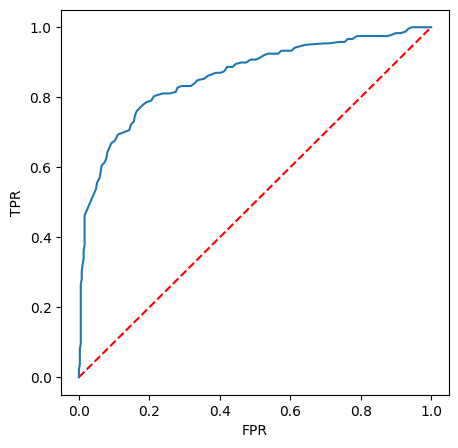

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [33]:
# ML Pipeline

from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, MinMaxScaler

# Gender
stringIndexer = StringIndexer(inputCol="Gender", outputCol="GenderIndexed")

# Age
imputer = Imputer(strategy="mean", inputCols=["Age"], outputCols=["AgeImputed"])

# Vectorize
inputCols = ["Pclass", "Sibsp", "Parch", "Fare", "GenderIndexed", "AgeImputed"]
assembler = VectorAssembler(inputCols=inputCols, outputCol="features")

# MinMaxScaler
minmax_scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

stages = [stringIndexer, imputer, assembler, minmax_scaler]

In [35]:
from pyspark.ml.classification import LogisticRegression

algo = LogisticRegression(featuresCol="features_scaled", labelCol="Survived")
lr_stages = stages + [algo]

In [36]:
lr_stages

[StringIndexer_efabe5156f14,
 Imputer_f205b34adb3b,
 VectorAssembler_b8ec4a1c9316,
 MinMaxScaler_787b7796b530,
 LogisticRegression_7c01615b41e6]

In [37]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=lr_stages)

In [38]:
df = data.select(["Survived", "Pclass", "Gender", "Age", "Sibsp", "Parch", "Fare"])
df.show()

+--------+------+------+----+-----+-----+-------+
|Survived|Pclass|Gender| Age|Sibsp|Parch|   Fare|
+--------+------+------+----+-----+-----+-------+
|       0|     3|  male|22.0|    1|    0|   7.25|
|       1|     1|female|38.0|    1|    0|71.2833|
|       1|     3|female|26.0|    0|    0|  7.925|
|       1|     1|female|35.0|    1|    0|   53.1|
|       0|     3|  male|35.0|    0|    0|   8.05|
|       0|     3|  male|null|    0|    0| 8.4583|
|       0|     1|  male|54.0|    0|    0|51.8625|
|       0|     3|  male| 2.0|    3|    1| 21.075|
|       1|     3|female|27.0|    0|    2|11.1333|
|       1|     2|female|14.0|    1|    0|30.0708|
|       1|     3|female| 4.0|    1|    1|   16.7|
|       1|     1|female|58.0|    0|    0|  26.55|
|       0|     3|  male|20.0|    0|    0|   8.05|
|       0|     3|  male|39.0|    1|    5| 31.275|
|       0|     3|female|14.0|    0|    0| 7.8542|
|       1|     2|female|55.0|    0|    0|   16.0|
|       0|     3|  male| 2.0|    4|    1| 29.125|


In [39]:
train, test = df.randomSplit([0.7, 0.3])

In [40]:
lr_model = pipeline.fit(train)
lr_cv_predictions = lr_model.transform(test)
evaluator.evaluate(lr_cv_predictions)

0.8656104752861208

ML Tuning

In [41]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="Survived", metricName="areaUnderROC")

In [42]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (
    ParamGridBuilder()
    .addGrid(algo.maxIter, [1, 5, 10]).build()
)

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

In [43]:
cvModel = cv.fit(train)
lr_cv_predictions = cvModel.transform(test)
evaluator.evaluate(lr_cv_predictions)

0.8670098455694936

In [44]:
lr_cv_predictions.select(["prediction", "Survived"]).show()

+----------+--------+
|prediction|Survived|
+----------+--------+
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       1.0|       0|
|       0.0|       0|
|       0.0|       0|
|       1.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
|       0.0|       0|
+----------+--------+
only showing top 20 rows



In [45]:
import pandas as pd

params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]
pd.DataFrame.from_dict([
    {cvModel.getEvaluator().getMetricName(): metric, **ps}
    for ps, metric in zip(params, cvModel.avgMetrics)
])

,areaUnderROC,maxIter
0,0.827647,1
1,0.843026,5
2,0.845552,10


In [46]:
# GBT Classifier
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="features_scaled", labelCol="Survived")
gbt_stages = stages + [gbt]

In [48]:
gbt_stages

[StringIndexer_efabe5156f14,
 Imputer_f205b34adb3b,
 VectorAssembler_b8ec4a1c9316,
 MinMaxScaler_787b7796b530,
 GBTClassifier_cf968af131c8]

In [50]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=gbt_stages)

In [51]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (
    ParamGridBuilder()
    .addGrid(gbt.maxDepth, [2, 4, 6])
    .addGrid(gbt.maxBins, [20, 60])
    .addGrid(gbt.maxIter, [10, 20])
    .build()
)

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

In [52]:
cvModel = cv.fit(train)
lr_cv_predictions = cvModel.transform(test)
evaluator.evaluate(lr_cv_predictions)

0.8785546504073166